# 0. Dataset Exploration

In this notebook, I'll be exploring methods for fraud detection.

This dataset was obtained here: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import recall_score, precision_score, accuracy_score, make_scorer, confusion_matrix

%matplotlib inline

As we can see below, we have 30 features in out credit car dataset. Sadly, most of them are anonymized so we don't know what they mean, but there's still relevant information there.

There are 284.807 examples in this dataset. 284315 are categorized as not fraud while 492 are considered fraud, this means our dataset is imbalanced and because of that, we have to take some precautions to not classify this data mistakenly.

In [2]:
cc_df = pd.read_csv('../../data/raw/kaggle/creditcard.csv')
cc_df.info()
cc_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Fraud Frequency Graph

It's shown by the graph below how imbalanced our dataset is.

0    284315
1       492
Name: Class, dtype: int64

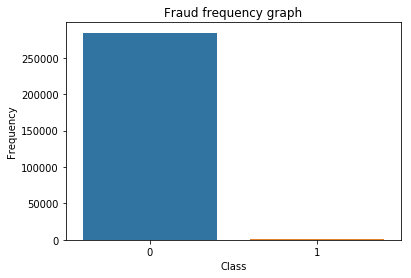

In [3]:
sns.barplot([0, 1], cc_df['Class'].value_counts())
plt.title("Fraud frequency graph")
plt.xlabel("Class")
plt.ylabel("Frequency")
cc_df['Class'].value_counts()

## Amount Distribution

Here we can check that most credit card transactions are for buying inexpensive items.

/Users/mikael/Dev/data-science-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


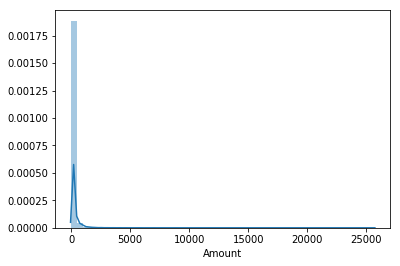

In [4]:
sns.distplot(cc_df.Amount)

## Classify using imbalanced data

We'll be trying to classify our data without any measure placed to help with the imbalanced data. It's expected that this classifier doesn't work very well in the real world, even if its accuracy is very high.

This happens because as most of our data belong to one class, our classifier learns that if it classifies most of the data as the majority class, it will predict correctly most of the time.

To help solve this issue, we'll use other metrics like recall and precision.

In [5]:
clf = DecisionTreeClassifier(random_state=0)
X = cc_df.drop(['Amount', 'Time', 'Class'], axis=1)
y = cc_df['Class']

In [6]:
cv_scores = cross_validate(clf, X, y, cv=10, scoring=['recall', 'precision', 'accuracy'], n_jobs=-1, return_train_score=False)

In [11]:
recall, precision, accuracy = cv_scores['test_recall'], cv_scores['test_precision'], cv_scores['test_accuracy']
print("Accuracy: {}".format(recall))
print("Precision: {}".format(precision))
print("Recall: {}".format(accuracy))

Accuracy: [0.88       0.52       0.85714286 0.71428571 0.69387755 0.71428571
 0.85714286 0.71428571 0.69387755 0.65306122]
Precision: [0.49438202 0.72222222 0.82352941 0.94594595 0.85       0.25547445
 0.63636364 0.68627451 0.75555556 0.69565217]
Recall: [0.9982094  0.99880626 0.99943822 0.99943822 0.99926267 0.99592697
 0.99891152 0.99894663 0.99908708 0.99891152]


## Plotting confusion matrix

In [8]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
y_pred = cross_val_predict(clf, X=X, y=y, cv=10, n_jobs=-1)


Accuracy: 0.9986938523280677
Precision: 0.6003344481605352
Recall: 0.7296747967479674
Confusion matrix, without normalization
[[284076    239]
 [   133    359]]


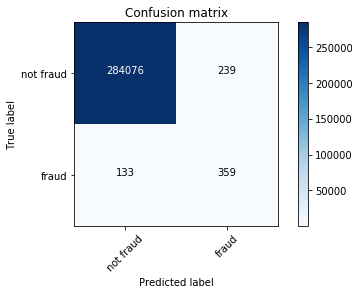

In [10]:
print("Accuracy: {}".format(accuracy_score(y, y_pred)))
print("Precision: {}".format(precision_score(y, y_pred)))
print("Recall: {}".format(recall_score(y, y_pred)))
confusion_matrix = confusion_matrix(y_pred=y_pred, y_true=y)
plot_confusion_matrix(confusion_matrix, classes=['not fraud', 'fraud'])

We can see the model is bad because, while it does have a high test accuracy, its recall and precision are low. That's happening because the data given to the model is highly imbalanced, so the model learns to predict the highest class in the training data.

We'll be exploring ways to solve this problem in the next notebook.